<a href="https://colab.research.google.com/github/51rL1N5/Prova_Esig/blob/master/houseprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inicialização do ambiente**

---



In [1]:
!pip install kaggle

!mkdir .kaggle
import json

token = {"username":"felipeols","key":"31e9d128303c584a875b2ffd1f394c91"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
    

In [0]:
!cp -r .kaggle ~/

In [3]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 26.7MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 62.4MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 61.8MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 10.6MB/s]


In [4]:
!pip install dask tqdm folium datashader bokeh feather-format

    100% |████████████████████████████████| 12.9MB 3.8MB/s 
    100% |████████████████████████████████| 81kB 26.9MB/s 
    100% |████████████████████████████████| 71kB 22.6MB/s 
    100% |████████████████████████████████| 1.6MB 19.6MB/s 
    100% |████████████████████████████████| 163kB 32.5MB/s 
    100% |████████████████████████████████| 48.5MB 718kB/s 
  Stored in directory: /root/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
Successfully built feather-format datashape
  Found existing installation: testpath 0.4.2
    Uninstalling testpath-0.4.2:
      Successfully uninstalled testpath-0.4.2


In [5]:
import pandas as pd
import numpy as np
import seaborn as sbs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

import dask.dataframe as dd
import os
from tqdm import tqdm


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go


import folium
import folium.plugins

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras import optimizers

from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno,Set1
from datashader import transfer_functions as tf
output_notebook()


Using TensorFlow backend.


Loading BokehJS ...

**EDA**

---



Primeiro, vamos ver a cara dos dados

In [6]:
train = pd.read_csv('train.csv')

train.head(25)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [7]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [9]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Agora, veremos a quantidade de dados faltantes (NaN)


In [0]:
def mostra_buraco():
  return train.columns[train.isnull().any()].tolist()

In [0]:
faltando = train[mostra_buraco()].isnull().sum()

In [12]:
faltando

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

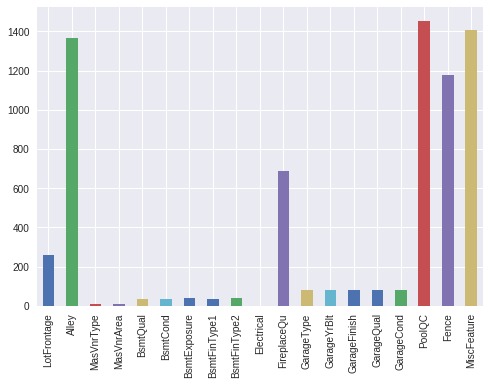

In [13]:
faltando.plot.bar()

In [0]:
tabela_faltando = train[mostra_buraco()]

In [15]:
train[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
0,Gd,TA,No,GLQ,Unf
1,Gd,TA,Gd,ALQ,Unf
2,Gd,TA,Mn,GLQ,Unf
3,TA,Gd,No,ALQ,Unf
4,Gd,TA,Av,GLQ,Unf
5,Gd,TA,No,GLQ,Unf
6,Ex,TA,Av,GLQ,Unf
7,Gd,TA,Mn,ALQ,BLQ
8,TA,TA,No,Unf,Unf
9,TA,TA,No,GLQ,Unf


Temos vários nans, como visto na parte acima. Podemos fazer duas abordagens:

   - Imputar novos valores
  
   - Dropar os dados que contém nans

**Dicionário das features faltando**

    - LotFrontage -> Frente do lote

    - Alley -> Tipo de beco para acessar a propriedade
    
    - MasVnrType -> 
    
    - BsmtXXXX -> variáveis do porão
    
    - Eletrical
    
    - FireplaceQu -> Quantidade de lareiras
    
    - GarageXXX   -> Variáveis relacionadas a garagem
    
    - PoolQc    -> Quantidade de piscina???
    
    - Fence   -> Tipo de certa/presença de
    
    - MiscFeature -> ??????

#Cuidando dos NaNs



---


**LotFrontage/LotArea**

In [16]:
# bora ver a correlação entra a LotFrontage e a LotArea já que a Area não tem valores faltando

train['LotFrontage'].corr(train['LotArea'])

0.42609501877180833

A correlação não é tão grande porque é complicado comparar
Uma dimensão quadrática (Area) com uma linear.

Vamos assumir que os lotes são quadrados e criar uma nova feature

In [0]:
train['Lado_do_lote'] = np.sqrt(train['LotArea'])

Vamos agora ve a correlação entre as features


In [18]:
train['LotFrontage'].corr(train['Lado_do_lote'])

0.6020022167939361

A correlação não é tão alta porque não dá para assumir que são retangulares. Todavia, iremos asumir que os lotes faltantes são

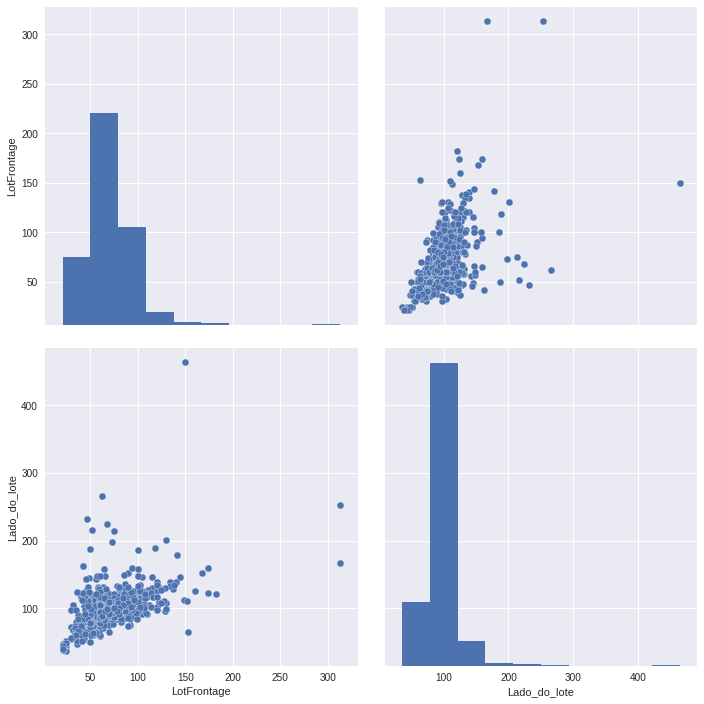

In [19]:
sbs.pairplot(data=train[['LotFrontage','Lado_do_lote']].dropna(), size=5)

Nesse pairplot, vemos que é razoável assumir que alguns terrenos podem ser quadrados

In [0]:
condicao = train['LotFrontage'].isnull()

train.LotFrontage[condicao] = train.Lado_do_lote[condicao]

Agora, já que o lado do lote já cumpriu seu papel, irei dropar essa feature

In [0]:
train = train.drop('Lado_do_lote',axis=1)

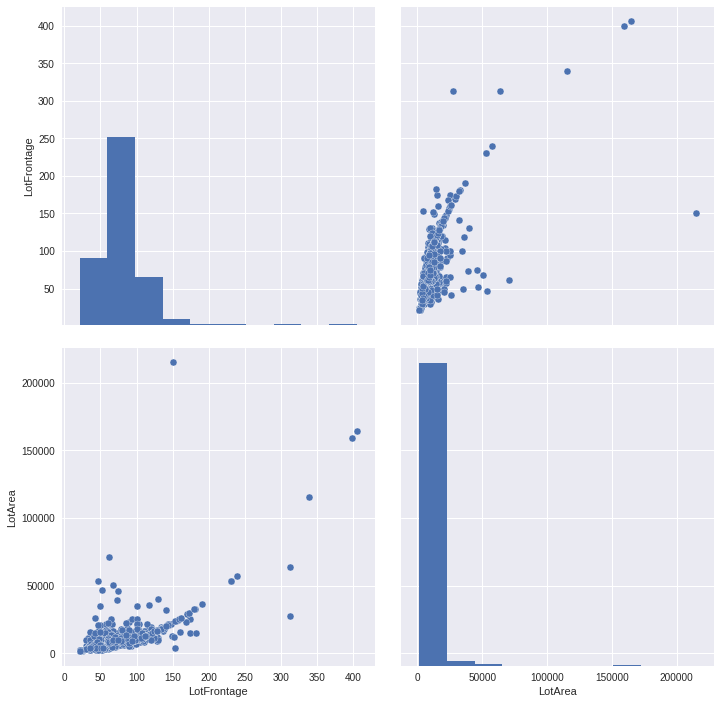

In [22]:
sbs.pairplot(data=train[['LotFrontage','LotArea']], size=5)

Nesse gráfico acima, vemos o motivo do coeficiente de correlação ter dado tão ruim para a comparação
Entre área e comprimento. Observe o comportamento quadrático

**Alley**

Primeiro, vamos ver quais os tipos dos Alley

In [23]:
train['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

Temos poucas casas com becos, e eles são: 

    - Pavimentados
    - Calçados
    
 Temos poucos elementos que tem Alley, a justificativa disso pode ser que as casas não terem acesso por beco. 
 
 Logo, trocarei NaN por None

In [0]:
# Bora imputar os valores

train.loc[train['Alley'].isnull(),'Alley'] = 'None'

In [25]:
train['Alley'].value_counts()

None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

MasVnr

In [26]:
train[['MasVnrType','MasVnrArea']][train['MasVnrType'].isnull()==True]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


Todos os valores de MasVnRXXXX que faltam estão na mesma linha, vou subistituir-los pelos mais frequentes

In [27]:
train['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

Agora, como None é o mais frequente do tipo, vou por 0.0 na area

In [0]:
# Bora imputar os valores

train.loc[train['MasVnrType'].isnull(),'MasVnrType'] = 'None'

train.loc[train['MasVnrArea'].isnull(), 'MasVnrArea'] = 0.0

**Basement**

In [0]:

basement_cols = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']

for cols in basement_cols:
    if 'FinSF'not in cols:
        train.loc[train[cols].isnull(),cols] = 'None'



**Electrical**

In [0]:
def mostra_dados(coluna):
  return train[coluna].value_counts()

def preenche_nans(coluna,valor):
  train.loc[train[coluna].isnull(),coluna] = valor

In [31]:
mostra_dados('Electrical')

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

O típo de rede elétrica mais utilizada é o SBrkr, vou imputar ele no lugar dos nans por ser o mais frequente. 

Pois, a probabilidade dessas caras que não tem isso preenchido ser SBrkr, é a maior possível dentre as escolhas.

In [0]:
preenche_nans('Electrical','SBrkr')

**Fireplace**

In [33]:
mostra_dados('FireplaceQu')

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [34]:
faltando['FireplaceQu']

690

Olhando a distribuição de Fireplaces por casa, vemos que o mais comum é não ter Fireplace

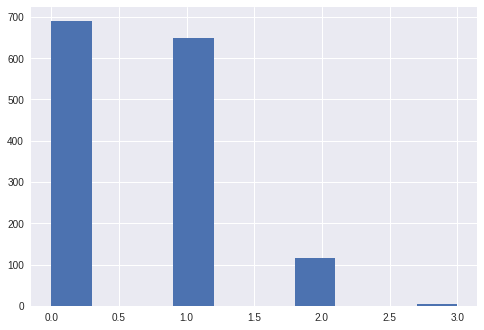

In [35]:
train['Fireplaces'].hist()

Vou assumir que os NaN quanto a fireplace são de pessoas que não tem fireplace.

In [0]:
preenche_nans('FireplaceQu','None')

In [37]:
pd.crosstab(train['Fireplaces'],train['FireplaceQu'])

FireplaceQu,Ex,Fa,Gd,None,Po,TA
Fireplaces,,,,,,
0,0,0,0,690,0,0
1,19,28,324,0,20,259
2,4,4,54,0,0,53
3,1,1,2,0,0,1


Isso mostra que a nossa assunção foi razoável

**Garages**

In [38]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']

train[garage_cols][train['GarageType'].isnull() == True]

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0,0
48,NaN,NaN,NaN,NaN,NaN,0,0
78,NaN,NaN,NaN,NaN,NaN,0,0
88,NaN,NaN,NaN,NaN,NaN,0,0
89,NaN,NaN,NaN,NaN,NaN,0,0
99,NaN,NaN,NaN,NaN,NaN,0,0
108,NaN,NaN,NaN,NaN,NaN,0,0
125,NaN,NaN,NaN,NaN,NaN,0,0
127,NaN,NaN,NaN,NaN,NaN,0,0
140,NaN,NaN,NaN,NaN,NaN,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8eda338d30>,
      dtype=object)

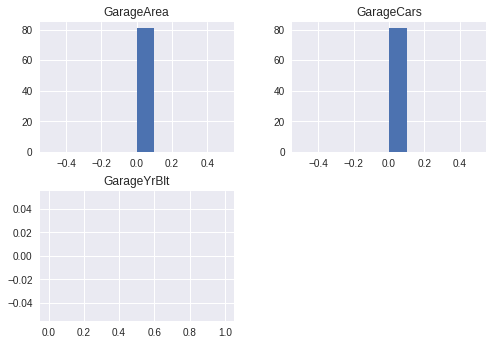

In [39]:
train[garage_cols][train['GarageType'].isnull() == True].hist()

Vemos que essas casas que não colocaram que tinham garagem simplesmente não tem mesmo.

Portanto, preencherei com None

In [0]:
for cols in garage_cols:
  # Caso em que tenhamos uma variável categórica
  if train[cols].dtype == np.object:
    preenche_nans(cols,'None')
  # Caso em que tenhamos variáveis numéricas
  else:
    preenche_nans(cols,0)

**Piscina**

In [41]:
mostra_dados('PoolQC')

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

Tem poucos dados não nulos, com respetio a qualidade das piscinas

Todavia, será que sempre que não tem dados, não tem piscina na casa?

Vamos fazer o seguinte: ver se as casas que não declararam esse parâmetro tem piscina, ao impor a seguinte condição:

Será que a área da piscina dessas casas é não nula?

In [42]:
train['PoolArea'][train['PoolQC'].isnull() == True].describe()

count    1453.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: PoolArea, dtype: float64

O banco de dados tem 1460 elementos, temos apenas 7 pessoas que declararam a qualidade da piscina. 

Então, esse resto que não declarou, de fato, não tme piscina em suas casas. Pois o valor máximo das áreas da piscina das pessoas que 
não declararam é 0

In [0]:
preenche_nans('PoolQC','None')

**Fence**

Vou assumir que as pessoas que não declararam que tem cerca, simplesmente não as tem

In [0]:
preenche_nans('Fence','None')

**MiscFeature**

Se a pessoa não declarou que tenha uma característica desse tipo, vou assumir que ela não tem

In [0]:
preenche_nans('MiscFeature','None')

##Dummyficar



In [0]:
train = pd.get_dummies(train)

# Hora da análise!

In [0]:
import scipy
import scipy.cluster.hierarchy as sch

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



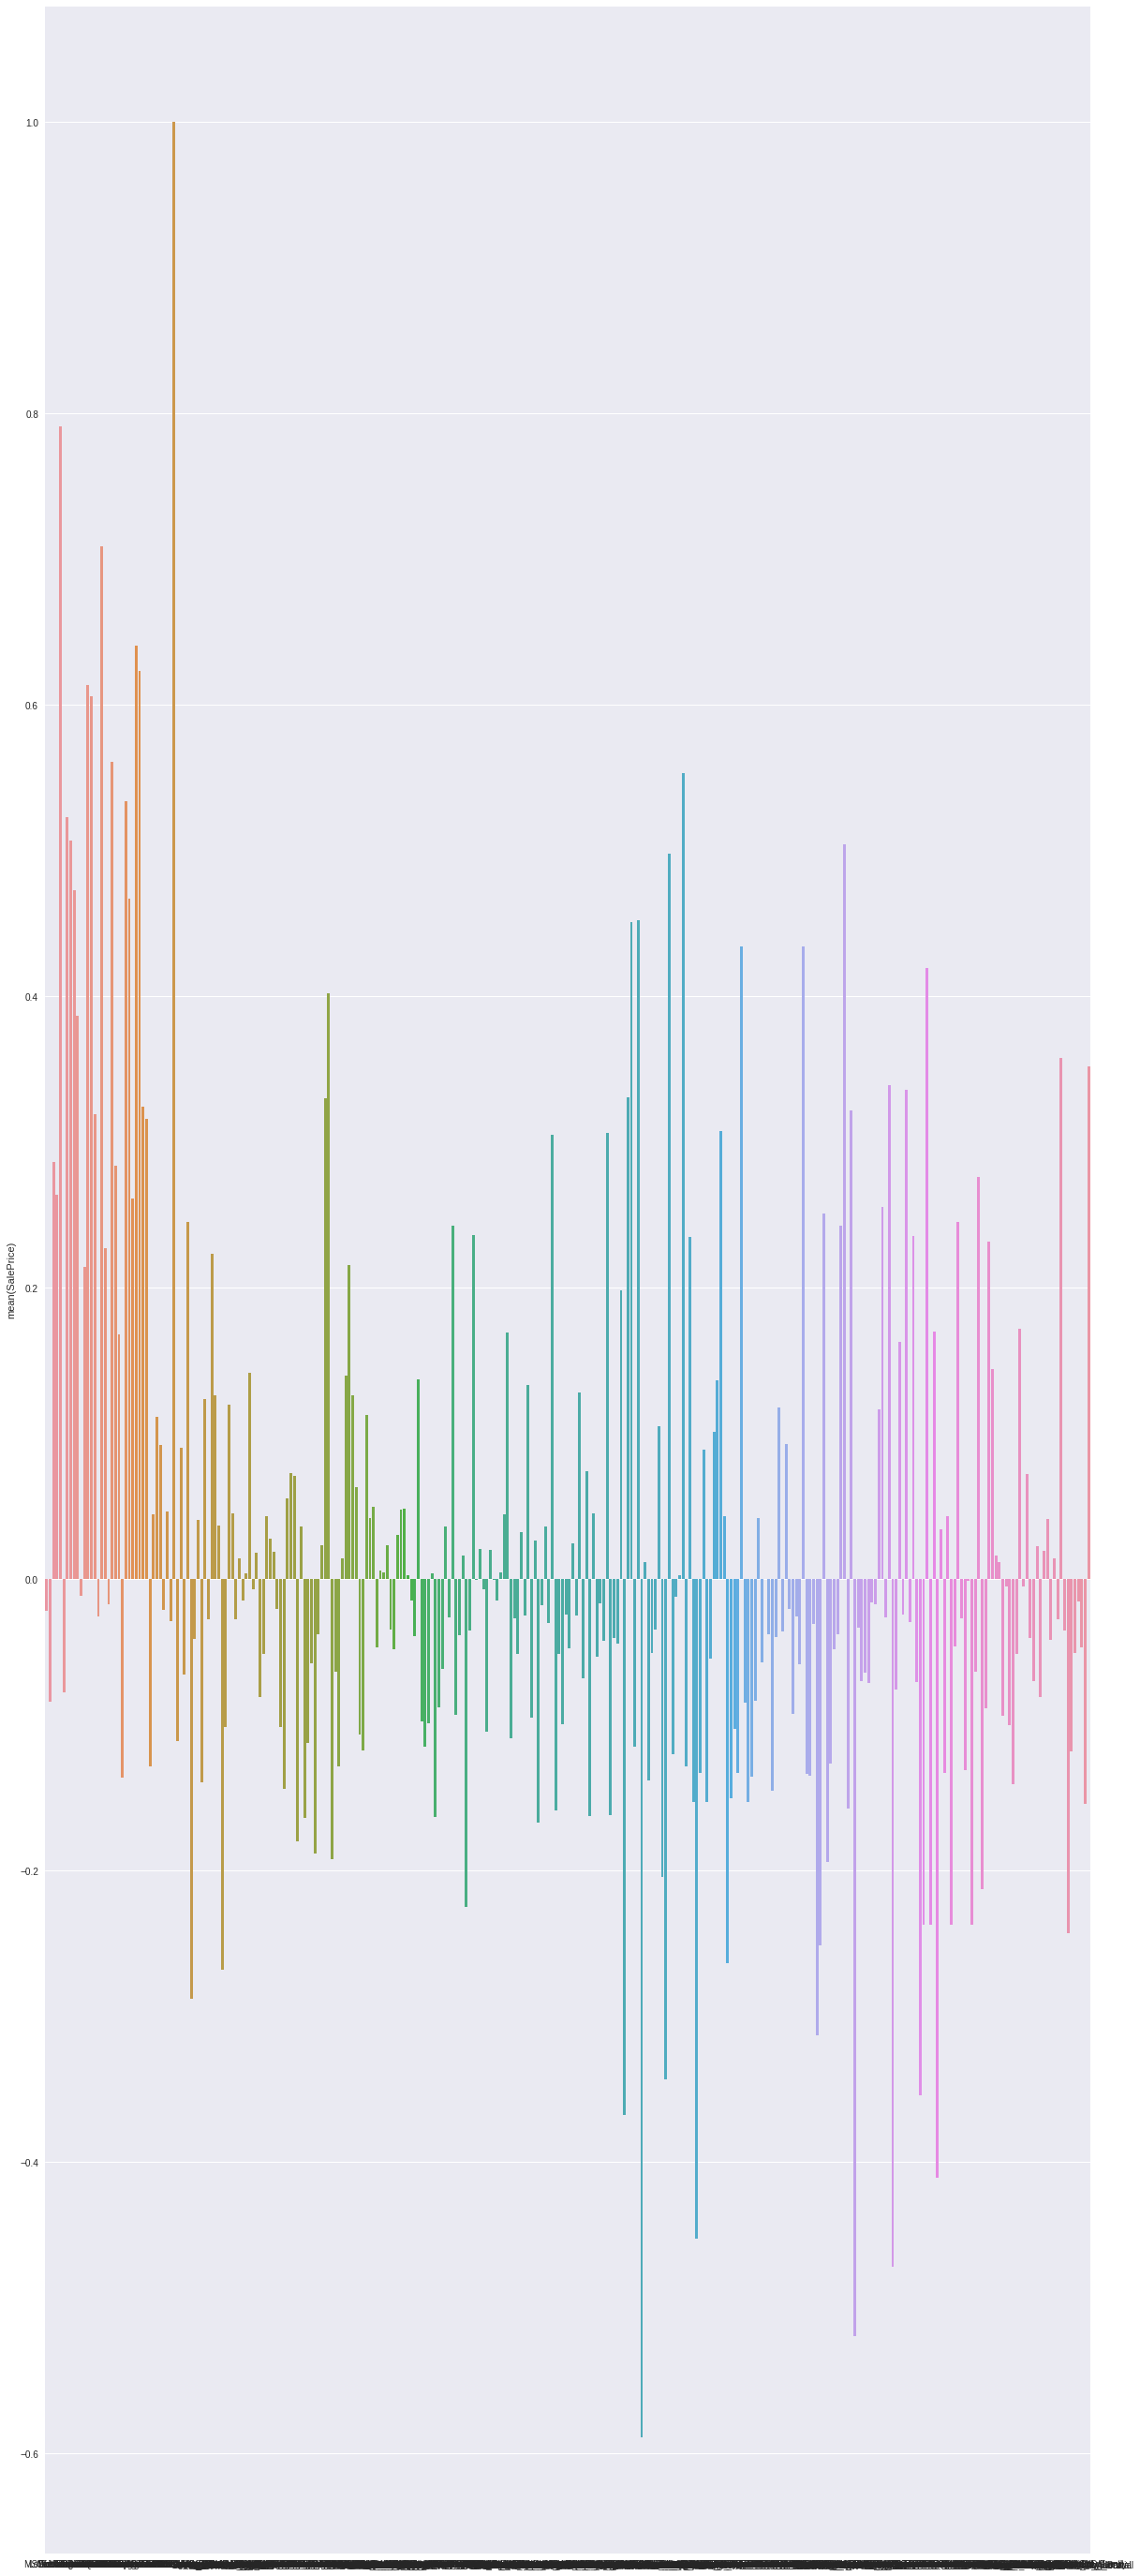

In [94]:
corr = train.corr()

corr_preco_de_venda = corr['SalePrice']


plt.figure(figsize=(20,50))
#corr_preco_de_venda
sbs.barplot(x=corr_preco_de_venda.index,y=corr_preco_de_venda)

Vou adotar um threshold de correlação de $|0.2|$

Jogarei fora todas as correlações que o módulo seja menor que isso

In [0]:
nova_corr = corr_preco_de_venda[np.abs(corr_preco_de_venda) >= 0.2]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



[Text(0, 0, 'LotFrontage'),
 Text(0, 0, 'LotArea'),
 Text(0, 0, 'OverallQual'),
 Text(0, 0, 'YearBuilt'),
 Text(0, 0, 'YearRemodAdd'),
 Text(0, 0, 'MasVnrArea'),
 Text(0, 0, 'BsmtFinSF1'),
 Text(0, 0, 'BsmtUnfSF'),
 Text(0, 0, 'TotalBsmtSF'),
 Text(0, 0, '1stFlrSF'),
 Text(0, 0, '2ndFlrSF'),
 Text(0, 0, 'GrLivArea'),
 Text(0, 0, 'BsmtFullBath'),
 Text(0, 0, 'FullBath'),
 Text(0, 0, 'HalfBath'),
 Text(0, 0, 'TotRmsAbvGrd'),
 Text(0, 0, 'Fireplaces'),
 Text(0, 0, 'GarageYrBlt'),
 Text(0, 0, 'GarageCars'),
 Text(0, 0, 'GarageArea'),
 Text(0, 0, 'WoodDeckSF'),
 Text(0, 0, 'OpenPorchSF'),
 Text(0, 0, 'SalePrice'),
 Text(0, 0, 'MSZoning_RL'),
 Text(0, 0, 'MSZoning_RM'),
 Text(0, 0, 'LotShape_IR1'),
 Text(0, 0, 'LotShape_Reg'),
 Text(0, 0, 'Neighborhood_NoRidge'),
 Text(0, 0, 'Neighborhood_NridgHt'),
 Text(0, 0, 'Neighborhood_StoneBr'),
 Text(0, 0, 'HouseStyle_2Story'),
 Text(0, 0, 'RoofStyle_Gable'),
 Text(0, 0, 'RoofStyle_Hip'),
 Text(0, 0, 'Exterior1st_VinylSd'),
 Text(0, 0, 'Exterior2nd_V

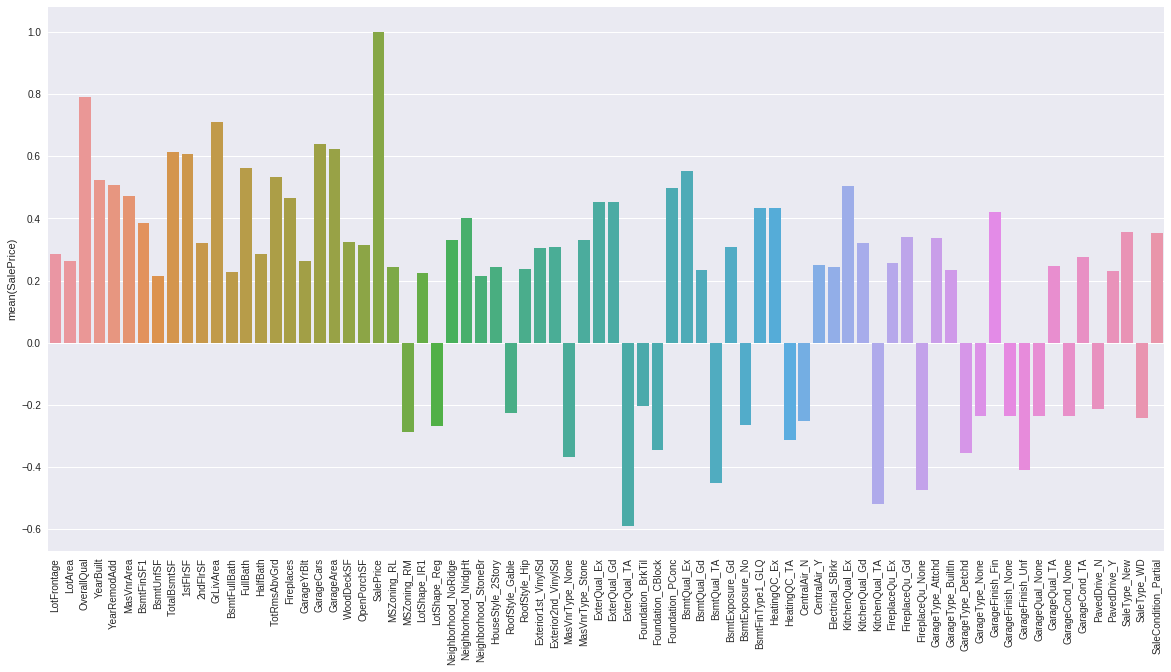

In [96]:
plt.figure(figsize=(20,10))

g = sbs.barplot(x=nova_corr.index,y=nova_corr)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

In [0]:
labels_relevantes = nova_corr.index.values
#treino_filtro1    = train[labels_relevantes]
#treino_filtro1

In [98]:
labels_relevantes

array(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'SalePrice', 'MSZoning_RL', 'MSZoning_RM',
       'LotShape_IR1', 'LotShape_Reg', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_StoneBr',
       'HouseStyle_2Story', 'RoofStyle_Gable', 'RoofStyle_Hip',
       'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'MasVnrType_None',
       'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA',
       'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc',
       'BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtExposure_Gd',
       'BsmtExposure_No', 'BsmtFinType1_GLQ', 'HeatingQC_Ex',
       'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_SBrkr',
    

In [0]:
labels_relevantes = ['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
                     'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
                     'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
                     'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
                     'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
                     'OpenPorchSF', 'SalePrice', 'MSZoning_RL', 'MSZoning_RM',
                     'LotShape_IR1', 'LotShape_Reg', 'Neighborhood_NoRidge',
                     'Neighborhood_NridgHt', 'Neighborhood_StoneBr',
                     'HouseStyle_2Story', 'RoofStyle_Gable', 'RoofStyle_Hip',
                     'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'MasVnrType_None',
                     'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA',
                     'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc',
                     'BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtExposure_Gd',
                     'BsmtExposure_No', 'BsmtFinType1_GLQ', 'HeatingQC_Ex',
                     'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_SBrkr',
                     'KitchenQual_Ex', 'KitchenQual_Gd', 'KitchenQual_TA',
                     'FireplaceQu_Ex', 'FireplaceQu_Gd', 'FireplaceQu_None',
                     'GarageType_Attchd', 'GarageType_BuiltIn', 'GarageType_Detchd',
                     'GarageType_None', 'GarageFinish_Fin', 'GarageFinish_None',
                     'GarageFinish_Unf', 'GarageQual_None', 'GarageQual_TA',
                     'GarageCond_None', 'GarageCond_TA', 'PavedDrive_N', 'PavedDrive_Y',
                     'SaleType_New', 'SaleType_WD', 'SaleCondition_Partial'
                     ]

train = train[labels_relevantes]

In [104]:
train.head(5)

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageFinish_Unf,GarageQual_None,GarageQual_TA,GarageCond_None,GarageCond_TA,PavedDrive_N,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Partial
0,65.0,8450,7,2003,2003,196.0,706,150,856,856,...,0,0,1,0,1,0,1,0,1,0
1,80.0,9600,6,1976,1976,0.0,978,284,1262,1262,...,0,0,1,0,1,0,1,0,1,0
2,68.0,11250,7,2001,2002,162.0,486,434,920,920,...,0,0,1,0,1,0,1,0,1,0
3,60.0,9550,7,1915,1970,0.0,216,540,756,961,...,1,0,1,0,1,0,1,0,1,0
4,84.0,14260,8,2000,2000,350.0,655,490,1145,1145,...,0,0,1,0,1,0,1,0,1,0


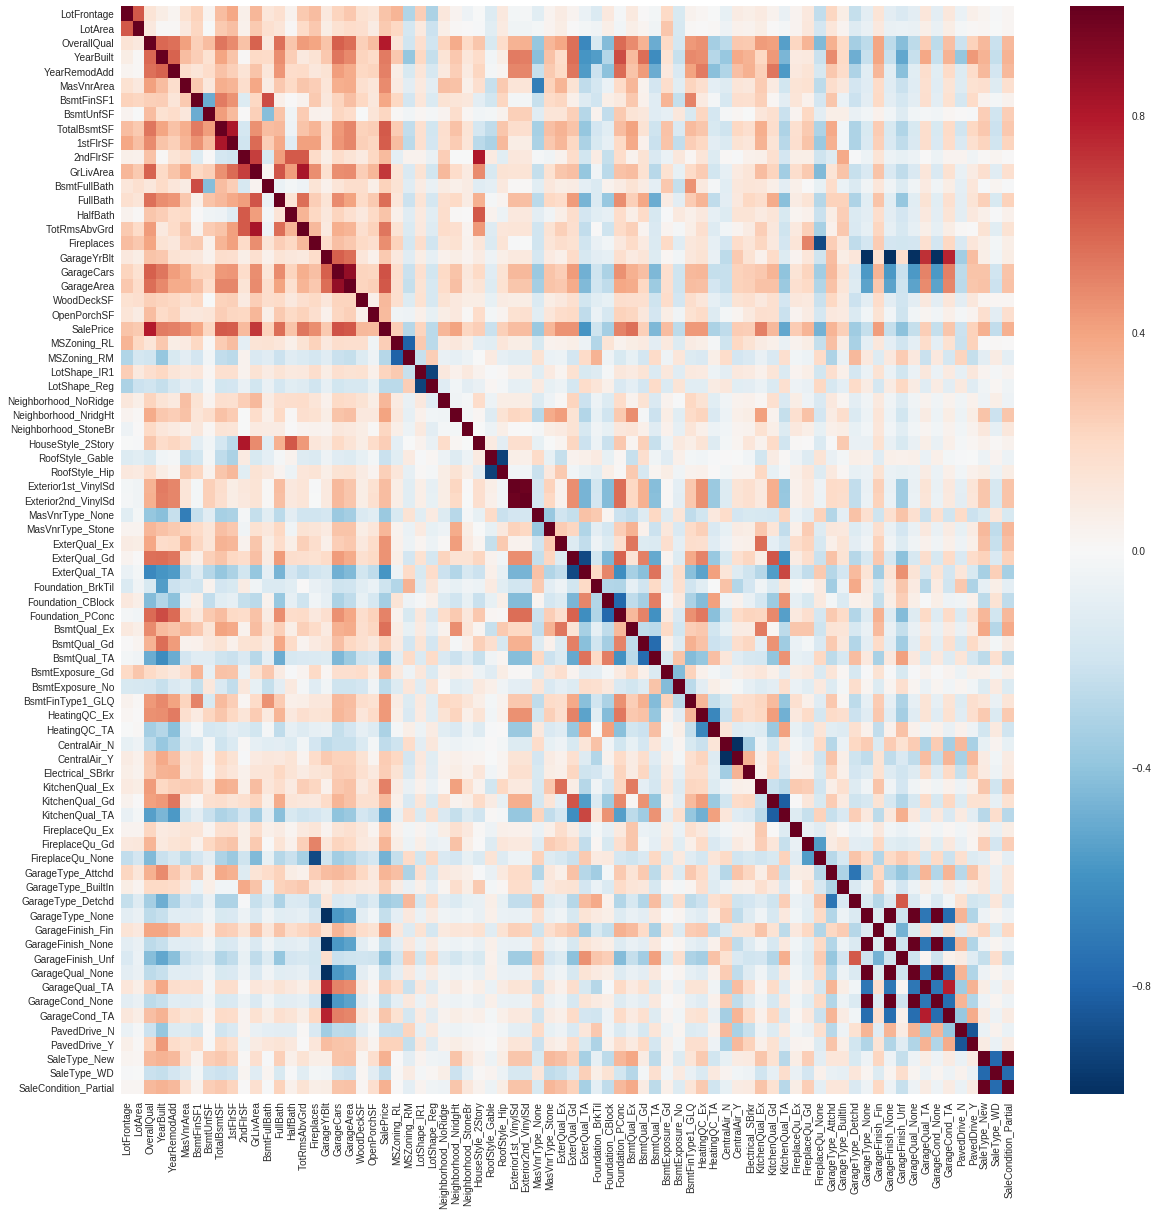

In [109]:
new_corr = train.corr()

plt.figure(figsize=(20,20))

sbs.heatmap(
            new_corr,
           )